# Train of a TensorFlow Lite model for Microcontrollers

This notebook demonstrates the process of training a model using TensorFlow and converting it for use with TensorFlow Lite for microcontrollers. The application is gesture recognition using features extracted from sEMG signals.

## Configure Defaults

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

# Defining path to save the entire keras model to a HDF5 file (for size 
# comparison with the TensorFlow Lite models later)
MODEL_TF_H5 = MODELS_DIR + 'model.h5'

## Setup Environment

Install Dependencies:

In [ ]:
! pip install tensorflow==2.4.0

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 132 kB 63.8 MB/s 
     |████████████████████████████████| 462 kB 42.4 MB/s 
     |████████████████████████████████| 3.8 MB 48.6 MB/s 
     |████████████████████████████████| 2.9 MB 42.6 MB/s 
     |████████████████████████████████| 14.8 MB 39.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=23e185fa87ea61d0dfa66b24266e61e382ad74bd280b58728dc50ba533c123ef
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting

Import Dependencies:

In [ ]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

## Dataset

### 1. Import and Process Data

In order to train a ML model, it is necessary to have a dataset. A dataset is a collection of labelled feature vectors, where a feature is a value that describes a sample of data somehow. In our case, the features are the MAV, ZC, SSC and WL of the Channels 1 and 2 data. A label is an informative value (or values) used to identify a particular feature vector. In our case, we use one-hot encoding for labelling, where each bit represents the probability from 0 to 1 the features belong to a particular gesture. For example, for Gesture 1 samples, there would be a probability of 1 in the first bit and a probability of 0 in the remaining bits, so the label would be [1, 0].

The code in the following cell will import the feature vectors of each sample (obtained from MATLAB), assign them a label ([1, 0] for Gesture 1 and [0, 1] for Gesture 2), and then mix the Gesture 1 and 2 datasets together. After that, the code splits the dataset into `x` (features) and `y` (labels) to appropriately feed it into the ML algorithm.

In [ ]:
#Importing .txt files containing the combined Channel 1 and Channel 2 sEMG 
#features for each gesture; each row corresponding to a different sample
data_gest1 = np.loadtxt('gest1.txt')
data_gest2 = np.loadtxt('gest2.txt')

#Creating labels for each gesture using one-hot encoding. Each gesture has a 
#label of 1 for its corresponding column and a label of 0 for all other 
#columns. Make sure the number of columns in each label is the same.
label_gest1 = np.tile(np.array([1,0], dtype=float), (len(data_gest1), 1))
label_gest2 = np.tile(np.array([0,1], dtype=float), (len(data_gest2), 1))

#Combining data from each gesture with its corresponding label
gest1 = np.concatenate((data_gest1, label_gest1), axis=1)
gest2 = np.concatenate((data_gest2, label_gest2), axis=1)

#Mixing the Gestures 1 and 2 data
if len(gest1) != len(gest2):        #Checking gest1 and gest2 have the same length
  print("Data for gestures 1 and 2 isn't the same size")
else:
    counter = 0    #Counter to be used in the for loop
    gestCombined = np.zeros((2*len(gest1),len(gest1[0])))   #Pre-allocating size for speed
    for n in range(0,len(gest1)):       #Combining data into array gestCombined
        gestCombined[counter] = gest1[n]
        counter = counter + 1
        gestCombined[counter] = gest2[n]
        counter = counter + 1

#Getting x and y values to feed into the algorithm. x has our features and y
#has the corresponding labels
gest_num = len(label_gest1[0])      #Number of gestures
x_values = np.zeros((len(gestCombined),len(gestCombined[0])-gest_num))     #Pre-allocating size for speed
y_values = np.zeros((len(gestCombined),gest_num))      #Pre-allocating size for speed
for k in range(0,len(gestCombined)):
    x_values[k] = gestCombined[k][0:len(gestCombined[n])-gest_num]
    y_values[k] = gestCombined[k][len(gestCombined[n])-gest_num:len(gestCombined[n])]

### 2. Split the Data

To evaluate the accuracy of the model, it is necessary to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing). It is important in both cases to use fresh data that was not already used to train the model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20%


In [ ]:
# Number of sample datapoints
samples = len(x_values)

# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculating the indices of each section
train_split =  int(0.6 * samples)
test_split = int(0.2 * samples + train_split)

# Choping x and y data into three parts
x_train = np.float32(x_values[0:train_split])
x_validate = np.float32(x_values[train_split:test_split])
x_test = np.float32(x_values[test_split:len(x_values)])

y_train = np.float32(y_values[0:train_split])
y_validate = np.float32(y_values[train_split:test_split])
y_test = np.float32(y_values[test_split:len(y_values)])

In [ ]:
type(x_train[1][1])

numpy.float32

## Training

### 1. Design the Model
We build a neural network model that takes `x` as an input value and uses it to predict the probability scores for each gesture (i.e. the `y`). This type of problem is called a regression, and the algorithm uses the layers of neurons to attempt to learn any patterns underlying the training data, so it can make predictions.

There are 3 layers of neurons. The first layer takes an input vector of length 6 (the `x` feature vector) and runs it through 26 neurons. Based on this input, each neuron will become activated to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from the first layer are then fed as inputs to the second layer, 17 neurons long, which applies its own _weights_ and _biases_ to these inputs to calculate its own activation. The activation numbers from the second layer are then fed as inputs to the third layer, and the process repeats until the final layer is reached. The last layer outputs a vector of length 2 (the `y` vector of probabilities).

The code in the following cell defines the model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, it is compiled with Categorical Crossentropy as the loss parameter and (Categorical) Accuracy as the performance metric. These parameters are normally used to measure the error in multi-class classification problems which use one-hot encoding, like it is our case ([How to solve Classification Problems in Deep Learning with Tensorflow & Keras?](https://medium.com/deep-learning-with-keras/how-to-solve-classification-problems-in-deep-learning-with-tensorflow-keras-6e39c5b09501)).

In [ ]:
#--- Creating the model architecture using Keras ---#
# Defining the model
model = tf.keras.Sequential()

# Adding the first layer. The neurons decide whether to activate based on the 
# 'relu' activation function.
model.add(keras.layers.Dense(26, activation='relu', input_shape=(6,)))

# Including additional layers. These layers will help the network learn more 
# complex representations
model.add(keras.layers.Dense(17, activation='relu'))

# Incorporating the final layer, 2 neurons long, in order to output a vector of
# length 2. The activation function used is 'softmax'
model.add(keras.layers.Dense(2, activation='softmax'))

# Compiling the model using the standard 'adam' optimizer, the
# 'categorical_crossentropy' loss function, and the 'accuracy' metric for 
# regression.
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

# Printing some summary information about the model's architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 26)                182       
_________________________________________________________________
dense_7 (Dense)              (None, 17)                459       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 36        
Total params: 677
Trainable params: 677
Non-trainable params: 0
_________________________________________________________________


### 2. Train the Model
Once the model is defined, we can use our data to train it. Training involves passing an `x` feature vector into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' _weights_ and _biases_ so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an epoch. During each epoch, data is run through the network in multiple batches. Each batch involves several pieces of data, which are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's _weights_ and _biases_ are adjusted accordingly, once per batch.

The code in the following cell uses the `x` and `y` from the training data to train the model. It runs for 1000 epochs, with 8 pieces of data in each batch. The validation data is also passed in for validation.


In [ ]:
# Train the model on our training data while validating on our validation set
history = model.fit(x_train, y_train, epochs=1000, batch_size=8,
                        validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)      # SavedModel format (to create the TensorFlow Lite models)
model.save(MODEL_TF_H5)   # HDF5 format (to compare with the TensorFlow Lite models size)

Epoch 1/1000
68/68 [==============================] - 1s 4ms/step - loss: 93.3916 - accuracy: 0.4988 - val_loss: 9.7512 - val_accuracy: 0.6278
Epoch 2/1000
68/68 [==============================] - 0s 2ms/step - loss: 8.2141 - accuracy: 0.6383 - val_loss: 3.3687 - val_accuracy: 0.7278
Epoch 3/1000
68/68 [==============================] - 0s 2ms/step - loss: 3.1153 - accuracy: 0.6834 - val_loss: 3.6575 - val_accuracy: 0.7222
Epoch 4/1000
68/68 [==============================] - 0s 2ms/step - loss: 2.2906 - accuracy: 0.7513 - val_loss: 1.5491 - val_accuracy: 0.7889
Epoch 5/1000
68/68 [==============================] - 0s 2ms/step - loss: 1.9811 - accuracy: 0.7631 - val_loss: 1.4381 - val_accuracy: 0.8056
Epoch 6/1000
68/68 [==============================] - 0s 2ms/step - loss: 3.7861 - accuracy: 0.6994 - val_loss: 2.1081 - val_accuracy: 0.7833
Epoch 7/1000
68/68 [==============================] - 0s 2ms/step - loss: 2.4383 - accuracy: 0.7355 - val_loss: 2.7173 - val_accuracy: 0.7722
Epoch

### 3. Plot Performance Metrics (Categorical Crossentropy and Categorical Accuracy)

The code in the following cell draws a graph of the loss (Categorical Crossentropy) and the performance metric (Categorical Accuracy) during training and validation (i.e. the distance between the predicted and actual values).

For training set:	Loss = 0.19842 	Accuracy = 0.9185 

For validation set:	Loss = 0.32720 	Accuracy = 0.8667 



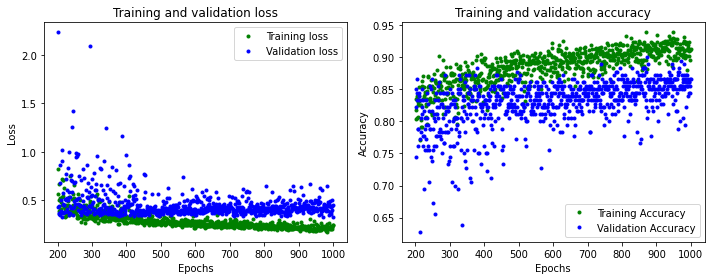

In [ ]:
# Calculate and print the loss on the training dataset
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print('\033[1m' + 'For training set:' + '\033[0m' + '\tLoss =',format(train_loss, ".5f"),'\tAccuracy =',format(train_accuracy, ".4f"),'\n')

# Calculate and print the loss on the validation dataset
val_loss, val_accuracy = model.evaluate(x_validate, y_validate, verbose=0)
print('\033[1m' + 'For validation set:' + '\033[0m' + '\tLoss =',format(val_loss, ".5f"),'\tAccuracy =',format(val_accuracy, ".4f"),'\n')

#--- Plotting the graphs ---#
# Exclude the first few epochs so the graph is easier to read
SKIP = 200

# Plotting the loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.subplot(1, 2, 2)

plt.plot(epochs[SKIP:], train_accuracy[SKIP:], 'g.', label='Training Accuracy')
plt.plot(epochs[SKIP:], val_accuracy[SKIP:], 'b.', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

### 4. Plot Predicted vs Actual values

In the following cells, the metrics of the test set are measured and the predicted and actual values of the whole dataset are plotted for comparison.

In [ ]:
#Function to prepare y values for the plot. It separates the Gesture 1
#labels from the Gesture 2 labels as they are mixed in vector y.
def prepareY4Plot(y):
  counter = -1
  y_gest1 = np.zeros((int(len(y)/gest_num),gest_num))
  y_gest2 = np.zeros((int(len(y)/gest_num),gest_num))
  for n in range(0,int(len(y)/gest_num)):
    counter = counter + 1
    y_gest1[n] = y[counter]
    counter = counter + 1
    y_gest2[n] = y[counter]
  return y_gest1, y_gest2

For test set:	Loss = 0.24676 	Accuracy = 0.9111 



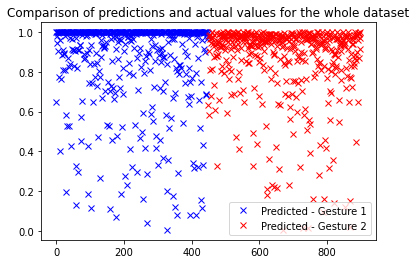


 For whole dataset:   Loss = 0.23384   Accuracy = 0.9067 



In [ ]:
# Calculate and print the loss on the test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print('\033[1m' + 'For test set:' + '\033[0m' + '\tLoss =',format(test_loss, ".5f"),'\tAccuracy =',format(test_accuracy, ".4f"),'\n')

# Make predictions based on the whole dataset
y_dataset_pred = model.predict(x_values)

# Preparing variables for the plot
y_dataset_gest1, y_dataset_gest2 = prepareY4Plot(y_values)
y_dataset_pred_gest1, y_dataset_pred_gest2 = prepareY4Plot(y_dataset_pred)

# Graph the predictions against the actual values
x_plot_gest1 = range(0,int(len(x_values)/2))
x_plot_gest2 = range(int(len(x_values)/2),len(x_values))
plt.clf()
plt.title('Comparison of predictions and actual values for the whole dataset')
#plt.plot(x_plot_gest1, y_dataset_gest1[:,0], 'bo', label='Actual - Gesture 1')
plt.plot(x_plot_gest1, y_dataset_pred_gest1[:,0], 'bx', label='Predicted - Gesture 1')
#plt.plot(x_plot_gest2, y_dataset_gest2[:,1], 'ro', label='Actual - Gesture 2')
plt.plot(x_plot_gest2, y_dataset_pred_gest2[:,1], 'rx', label='Predicted - Gesture 2')
plt.legend()
plt.show()

# Calculate and print the loss on the whole dataset
dataset_loss, dataset_accuracy = model.evaluate(x_values, y_values, verbose=0)
print('\n','\033[1m' + 'For whole dataset:' + '\033[0m' + '   Loss =',format(dataset_loss, ".5f"),'  Accuracy =',format(dataset_accuracy, ".4f"),'\n')

## Generate a TensorFlow Lite Model

### 1. Generate Models with or without Quantization
Now that we have a model, we will use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert it into a special, space-efficient format for use on memory-constrained devices (such as microcrocontrollers). Since the model is going to be deployed on a microcontroller, you want it to be as tiny as possible.

One additional technique for reducing the size of the model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's _weights_, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, the model will be converted to TensorFlow Lite format twice, once with quantization and once without.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
x_values = np.float32(x_values)   #It is required to use float data type format
def representative_dataset():
  for i in range(len(x_values)):
    yield([x_values[i]])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

3488

### 2. Compare Model Performance

In the following cells, to prove these models are accurate even after conversion and quantization, we'll compare their predictions and performance metrics on our test dataset.

***Note:***
*The `predict` (for predictions) and `evaluate` (for loss and accuracy) functions are defined to be able to use them on the TFLite models. (These are already included in a TF model, but not in  a TFLite model.)*

In [ ]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test = np.float32(x_test)   #It is required to use float data type format
  x_test_ = x_test

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty((len(x_test_),gest_num), dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  #Loss
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  #Accuracy
  accuracy_function = tf.keras.metrics.CategoricalAccuracy()
  accuracy_function.update_state(y_true, y_pred)
  accuracy = accuracy_function.result().numpy()
  return loss, accuracy

**1. Predictions**

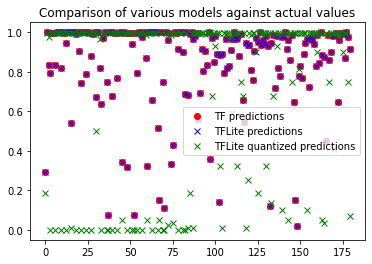

In [ ]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

# Preparing variables for the plot
y_test_gest1, y_test_gest2 = prepareY4Plot(y_test)
y_test_pred_tf_gest1, y_test_pred_tf_gest2 = prepareY4Plot(y_test_pred_tf)
y_test_pred_no_quant_tflite_gest1, y_test_pred_no_quant_tflite_gest2 = prepareY4Plot(y_test_pred_no_quant_tflite)
y_test_pred_tflite_gest1, y_test_pred_tflite_gest2 = prepareY4Plot(y_test_pred_tflite)

# Compare the predictions
x_plot_gest1 = range(0,int(len(x_test)/2))
x_plot_gest2 = range(int(len(x_test)/2),len(x_test))
plt.clf()
plt.title('Comparison of various models against actual values')
#plt.plot(x_plot_gest1, y_test_gest1[:,0], 'ko', label='Actual values')
#plt.plot(x_plot_gest2, y_test_gest2[:,1], 'ko')
plt.plot(x_plot_gest1, y_test_pred_tf_gest1[:,0], 'ro', label='TF predictions')
plt.plot(x_plot_gest2, y_test_pred_tf_gest2[:,1], 'ro')
plt.plot(x_plot_gest1, y_test_pred_no_quant_tflite_gest1[:,0], 'bx', label='TFLite predictions')
plt.plot(x_plot_gest2, y_test_pred_no_quant_tflite_gest2[:,1], 'bx')
plt.plot(x_plot_gest1, y_test_pred_tflite_gest1[:,0], 'gx', label='TFLite quantized predictions')
plt.plot(x_plot_gest2, y_test_pred_tflite_gest2[:,1], 'gx')
plt.legend()
plt.show()

**2. Loss (Categorical Crossentropy) and Accuracy (Categorical)**

In [ ]:
# Calculate loss
loss_tf, accuracy_tf = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite, accuracy_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite, accuracy_tflite = evaluate_tflite(model_tflite, x_test, y_test)
import statistics
loss_no_quant_tflite = statistics.mean(loss_no_quant_tflite)
loss_tflite = statistics.mean(loss_tflite)

# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf, accuracy_tf],
     ["TensorFlow Lite", loss_no_quant_tflite, accuracy_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite, accuracy_tflite]],
     columns = ["Model", "Loss", "Accuracy"], index="Model")
df

,Loss,Accuracy
Model,,
TensorFlow,0.246759,0.911111
TensorFlow Lite,0.246759,0.911111
TensorFlow Lite Quantized,2.648698,0.716667


**3. File Size**

In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF_H5)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(further reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,41144 bytes,
TensorFlow Lite,4384 bytes,(reduced by 36760 bytes)
TensorFlow Lite Quantized,3488 bytes,(further reduced by 896 bytes)


## Generate a TensorFlow Lite for Microcontrollers Model
The following cell converts the TensorFlow Lite model into a C source file that can be loaded by TensorFlow Lite for microcontrollers.

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


## Deploy to a Microcontroller

In our case, we are interested in deploying the model to an Arduino Nano 33 BLE. To do this, the array in the C source file is copied and pasted into one of the examples of the Arduino_TensorFlowLite library in Arduino, and the corresponding array length is substituted as well.

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char models_model_no_quant_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x20, 0x00, 0x00, 0x00, 0x40, 0x01, 0x00, 0x00,
  0x20, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0xd4, 0x03, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x44, 0x01, 0x00, 0x00, 0x0d, 0x00, 0x00, 0x00,
  0xc8, 0x10, 0x00, 0x00, 0xc4, 0x10, 0x00, 0x00, 0xf8, 0x0f, 0x00, 0x00,
  0x64, 0x0f, 0x00, 0x00, 0xb8, 0x0e, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00,
  0xd0, 0x04, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0xa8, 0x10, 0x00, 0x00,
  0xa4, 0x10, 0x00, 0x00, 0xa0, 0x10, 0x00, 0x00, 0x9c, 0x10, 0x00, 0x00,
  0xcc, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0